In [9]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Carica i dati da file Excel
fragments_drug = pd.read_excel('uf_fragments_clusters_drug.xlsx', sheet_name='Fragments Clusters')       # Sostituisci 'Drug' con il nome del tuo foglio
fragments_nondrug = pd.read_excel('uf_fragments_clusters_non_drug.xlsx', sheet_name='Fragments Clusters') # Sostituisci 'NonDrug' con il nome del tuo foglio

# Verifica il caricamento
print("Frammenti Drug:")
print(fragments_drug.head())
print("\nFrammenti Non-Drug:")
print(fragments_nondrug.head())


Frammenti Drug:
           SMILES  Cluster                                        ID Molecola  \
0  O[C@@H]1CCCOC1        1  1, 1, 1, 1, 70, 70, 70, 70, 72, 72, 72, 73, 73...   
1              CC        2  2, 2, 2, 60, 60, 60, 60, 60, 60, 60, 60, 61, 6...   
2       Oc1ccccc1        1  1, 1, 74, 74, 194, 194, 194, 195, 196, 196, 19...   
3       OC1CCOCC1        1  1, 1, 70, 70, 72, 72, 73, 74, 81, 81, 82, 82, ...   
4             C=O        0  68, 68, 69, 69, 72, 72, 72, 73, 74, 81, 82, 83...   

   Count  Count%  Image  
0  20824     NaN    NaN  
1  20465     NaN    NaN  
2  12222     NaN    NaN  
3  11028     NaN    NaN  
4  10310     NaN    NaN  

Frammenti Non-Drug:
      SMILES  Cluster                                        ID Molecola  \
0         CC        2  3, 3, 3, 3, 4, 5, 66, 71, 75, 76, 77, 78, 79, ...   
1        COC        2  4, 7592, 7592, 7592, 7592, 7592, 7592, 7592, 7...   
2  Oc1ccccc1        5  75, 100, 664, 664, 806, 806, 806, 1113, 1113, ...   
3        C=O    

In [10]:
# Aggiungi una colonna per la classe
fragments_drug['Classe'] = 'Drug'
fragments_nondrug['Classe'] = 'Non-Drug'

# Unisci i due DataFrame
fragments_combined = pd.concat([fragments_drug, fragments_nondrug], ignore_index=True)

# Verifica l'unione
print("\nDati Combinati:")
print(fragments_combined.head())



Dati Combinati:
           SMILES  Cluster                                        ID Molecola  \
0  O[C@@H]1CCCOC1        1  1, 1, 1, 1, 70, 70, 70, 70, 72, 72, 72, 73, 73...   
1              CC        2  2, 2, 2, 60, 60, 60, 60, 60, 60, 60, 60, 61, 6...   
2       Oc1ccccc1        1  1, 1, 74, 74, 194, 194, 194, 195, 196, 196, 19...   
3       OC1CCOCC1        1  1, 1, 70, 70, 72, 72, 73, 74, 81, 81, 82, 82, ...   
4             C=O        0  68, 68, 69, 69, 72, 72, 72, 73, 74, 81, 82, 83...   

   Count  Count%  Image Classe  %Count  
0  20824     NaN    NaN   Drug     NaN  
1  20465     NaN    NaN   Drug     NaN  
2  12222     NaN    NaN   Drug     NaN  
3  11028     NaN    NaN   Drug     NaN  
4  10310     NaN    NaN   Drug     NaN  


In [14]:
# Raggruppa per SMILES e Classe, sommando i counts
frequency_table = fragments_combined.groupby(['SMILES', 'Classe'])['Count'].sum().unstack(fill_value=0)

# Aggiungi colonne per totali
frequency_table['Total'] = frequency_table.sum(axis=1)

# Calcola le frequenze relative
frequency_table['Freq_Drug'] = frequency_table['Drug'] / fragments_drug['Count'].sum()
frequency_table['Freq_NonDrug'] = frequency_table['Non-Drug'] / fragments_nondrug['Count'].sum()

# Reset index per facilitare l'analisi
frequency_table = frequency_table.reset_index()

print("\nTabella di Frequenza:")
frequency_table



Tabella di Frequenza:


Classe,SMILES,Drug,Non-Drug,Total,Freq_Drug,Freq_NonDrug
0,B1C2CCCC1CCC2,0,1,1,0.000000,0.000025
1,BF,3,0,3,0.000022,0.000000
2,Bc1ccccc1,2,0,2,0.000015,0.000000
3,BrC1=CC=CCC1,0,1,1,0.000000,0.000025
4,BrC1=CCCC=C1,0,1,1,0.000000,0.000025
...,...,...,...,...,...,...
1227,c1nc2cnncc2[nH]1,0,1,1,0.000000,0.000025
1228,c1ncc2[nH]cnc2n1,0,2,2,0.000000,0.000049
1229,c1ncc2nc[nH]c2n1,1,7,8,0.000007,0.000172
1230,c1occ2c1CCC2,0,1,1,0.000000,0.000025


In [17]:
# Inizializza liste per i risultati
p_values = []
odds_ratios = []
smiles_list = []

# Totali per classe
total_drug = fragments_drug['Count'].sum()
total_nondrug = fragments_nondrug['Count'].sum()

for index, row in frequency_table.iterrows():
    smiles = row['SMILES']
    drug_count = row['Drug']
    nondrug_count = row['Non-Drug']
    
    # Costruisci la matrice di contingenza
    contingency = np.array([[drug_count, nondrug_count],
                            [total_drug - drug_count, total_nondrug - nondrug_count]])
    
    # Calcola il test chi-quadrato
    try:
        chi2, p, dof, ex = chi2_contingency(contingency)
    except:
        p = 1.0  # In caso di errore, assegna p-value non significativo
    
    p_values.append(p)
    
    # Calcola l'odds ratio
    if nondrug_count == 0 or (total_drug - drug_count) == 0:
        odds_ratio = np.nan
    else:
        odds_ratio = (drug_count / (total_drug - drug_count)) / (nondrug_count / (total_nondrug - nondrug_count))
    odds_ratios.append(odds_ratio)
    
    smiles_list.append(smiles)

# Aggiungi i risultati al DataFrame
frequency_table['p-value'] = p_values
frequency_table['Odds_Ratio'] = odds_ratios

# Rimuovi i frammenti con odds ratio non definiti
frequency_table = frequency_table.dropna(subset=['Odds_Ratio'])

# Applica la correzione per i confronti multipli
frequency_table['p-value_adj'] = multipletests(frequency_table['p-value'], method='fdr_bh')[1]

# Definisci un criterio di significatività, ad esempio p-value_adj < 0.05
significant_fragments = frequency_table[frequency_table['p-value_adj'] < 0.05]

# Salva i risultati su file Excel
frequency_table.to_excel('frequency_table.xlsx', index=False)

print("\nFrammenti Significativi dopo Correzione:")
significant_fragments



Frammenti Significativi dopo Correzione:


C:\Users\Marco\AppData\Local\Temp\ipykernel_22260\3680252996.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency_table['p-value'] = p_values
C:\Users\Marco\AppData\Local\Temp\ipykernel_22260\3680252996.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency_table['Odds_Ratio'] = odds_ratios


Classe,SMILES,Drug,Non-Drug,Total,Freq_Drug,Freq_NonDrug,p-value,Odds_Ratio,p-value_adj
5,BrC1CCCCCCCCCCC1,0,18,18,0.000000,0.000442,1.030113e-13,0.000000,1.333997e-12
10,C#CC,21,30,51,0.000156,0.000736,4.690499e-09,0.211526,4.141497e-08
14,C1=C2CCC2CCC1,0,3,3,0.000000,0.000074,1.365428e-02,0.000000,4.439071e-02
18,C1=C2CCCC[C@@H]2CCC1,0,3,3,0.000000,0.000074,1.365428e-02,0.000000,4.439071e-02
21,C1=C2OCOC2=CCC1,6,16,22,0.000045,0.000393,1.536486e-07,0.113344,1.218214e-06
...,...,...,...,...,...,...,...,...,...
1207,c1ccc2nccnc2c1,0,3,3,0.000000,0.000074,1.365428e-02,0.000000,4.439071e-02
1210,c1ccc2occc2c1,27,86,113,0.000200,0.002110,7.767935e-40,0.094744,2.874136e-38
1216,c1ccncc1,4,21,25,0.000030,0.000515,3.356312e-12,0.057564,3.835080e-11
1224,c1cnc2occc2c1,0,4,4,0.000000,0.000098,2.325693e-03,0.000000,9.510861e-03


d:\Desktop\Tesi\DrugLikeness-prediction-and-Fragment-analysis\.venv\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


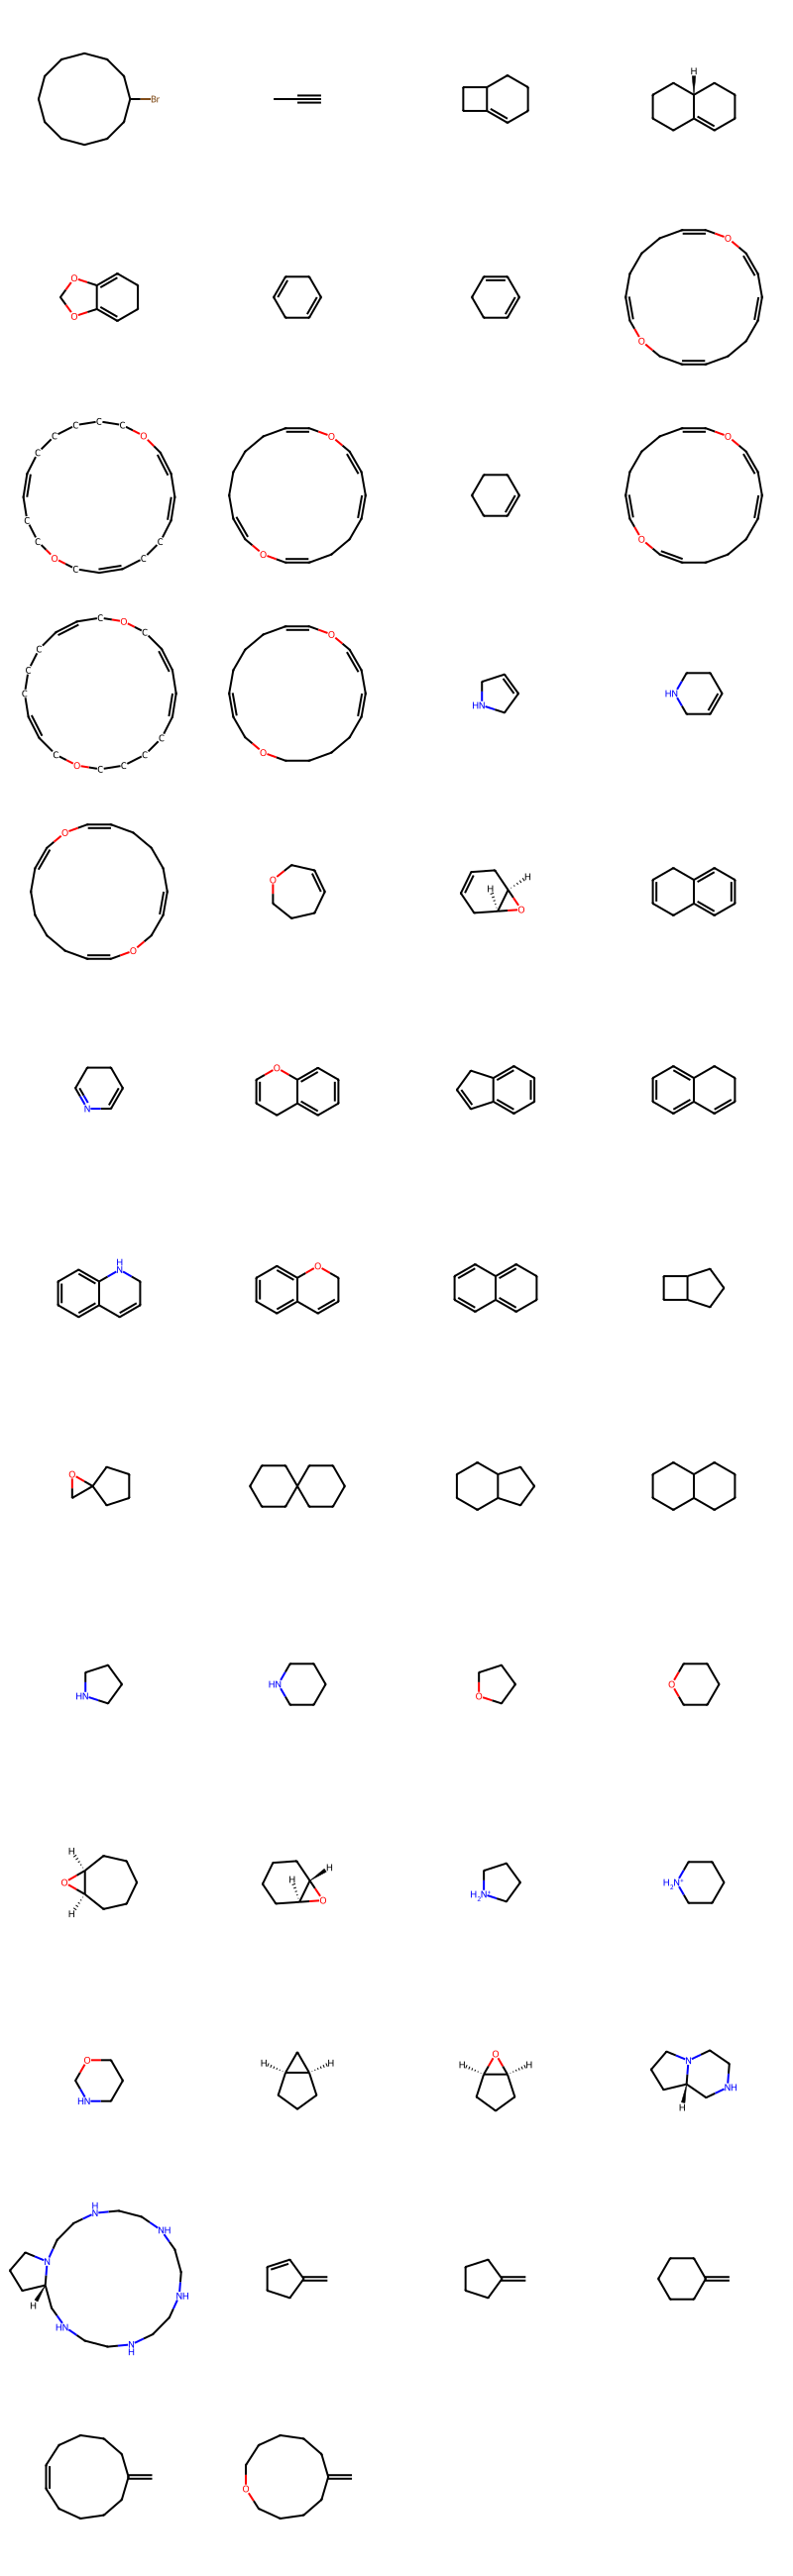

In [15]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in significant_fragments['SMILES']], molsPerRow=4, subImgSize=(200, 200))

1. Filtrare i Frammenti Significativi
Prima di tutto, devi identificare quali frammenti sono significativamente arricchiti nelle molecole Drug-like rispetto a quelle Non-Drug-like e viceversa. Questo si basa sui p-value aggiustati (p-value_adj) e sull'Odds_Ratio.

a. Selezionare Frammenti Significativi Arricchiti nelle Drug

In [18]:
import pandas as pd

# Carica il tuo file Excel o CSV con la tabella dei risultati
# Supponiamo che tu abbia già caricato i dati in 'frequency_table'

# Filtra per frammenti significativamente arricchiti nelle Drug
significant_drug_fragments = frequency_table[
    (frequency_table['p-value_adj'] < 0.05) &
    (frequency_table['Odds_Ratio'] > 1)
]

print("Frammenti significativamente arricchiti nelle Drug:")
print(significant_drug_fragments[['SMILES', 'Odds_Ratio', 'p-value_adj']].head())


Frammenti significativamente arricchiti nelle Drug:
Classe      SMILES  Odds_Ratio  p-value_adj
83       C1=CCCCC1    2.133532     0.009511
249        C1CCOC1    2.579881     0.000435
334      C=C1CCCC1    2.157725     0.023571
340     C=C1CCCCC1    1.564303     0.008724
447      CC1=COCC1    3.403109     0.003186


b. Selezionare Frammenti Significativi Arricchiti nelle Non-Drug

In [19]:
# Filtra per frammenti significativamente arricchiti nelle Non-Drug
significant_nondrug_fragments = frequency_table[
    (frequency_table['p-value_adj'] < 0.05) &
    (frequency_table['Odds_Ratio'] < 1)
]

print("Frammenti significativamente arricchiti nelle Non-Drug:")
print(significant_nondrug_fragments[['SMILES', 'Odds_Ratio', 'p-value_adj']].head())


Frammenti significativamente arricchiti nelle Non-Drug:
Classe                SMILES  Odds_Ratio   p-value_adj
5           BrC1CCCCCCCCCCC1    0.000000  1.333997e-12
10                      C#CC    0.211526  4.141497e-08
14             C1=C2CCC2CCC1    0.000000  4.439071e-02
18      C1=C2CCCC[C@@H]2CCC1    0.000000  4.439071e-02
21           C1=C2OCOC2=CCC1    0.113344  1.218214e-06


2. Analizzare l'Odds Ratio
L'Odds_Ratio (OR) fornisce una misura dell'associazione tra la presenza di un frammento e la classe della molecola. È fondamentale interpretare correttamente questi valori.

a. Interpretazione dell'Odds Ratio
OR > 1: Il frammento è più comune nelle molecole Drug-like.
OR < 1: Il frammento è più comune nelle molecole Non-Drug-like.
OR = 1: Nessuna associazione.

In [20]:
# Ordinare i frammenti arricchiti nelle Drug per Odds Ratio decrescente
top_enriched_drug = significant_drug_fragments.sort_values(by='Odds_Ratio', ascending=False).head(10)
print("Top 10 Frammenti Arricchiti nelle Drug:")
print(top_enriched_drug[['SMILES', 'Odds_Ratio', 'p-value_adj']])

# Ordinare i frammenti arricchiti nelle Non-Drug per Odds Ratio crescente
top_enriched_nondrug = significant_nondrug_fragments.sort_values(by='Odds_Ratio').head(10)
print("\nTop 10 Frammenti Arricchiti nelle Non-Drug:")
print(top_enriched_nondrug[['SMILES', 'Odds_Ratio', 'p-value_adj']])


Top 10 Frammenti Arricchiti nelle Drug:
Classe          SMILES  Odds_Ratio    p-value_adj
641      C[C@H]1CCCCO1   21.090655  1.610657e-142
1025         OC1CCOCC1   11.259198   0.000000e+00
622     C[C@H]1CC=CCC1    9.449743   1.300733e-55
970          OC1=CCCC1    8.922968   2.133661e-03
598     C[C@@H]1CCCOC1    7.765459   6.902911e-14
612     C[C@H]1C=CCCC1    5.727329   1.109203e-54
489          CC1CCCCC1    3.698099  5.287060e-228
447          CC1=COCC1    3.403109   3.186187e-03
1074     O[C@@H]1CCCO1    2.949098   1.361570e-02
485           CC1CCCC1    2.812589   4.707550e-33

Top 10 Frammenti Arricchiti nelle Non-Drug:
Classe                      SMILES  Odds_Ratio   p-value_adj
5                 BrC1CCCCCCCCCCC1         0.0  1.333997e-12
14                   C1=C2CCC2CCC1         0.0  4.439071e-02
18            C1=C2CCCC[C@@H]2CCC1         0.0  4.439071e-02
68                      C1=CCC=CC1         0.0  4.305845e-04
78       C1=CCCC=CCOC=CCCCC=COC=C1         0.0  4.451174e-09

3. Visualizzare i Frammenti Differenziali
Le visualizzazioni aiutano a comprendere meglio i risultati e a comunicare le scoperte. Ecco alcune tecniche di visualizzazione utili:

a. Volcano Plot
Un Volcano Plot combina l'informazione sull'effetto (log2 OR) con la significatività (−log10 p-value aggiustato), permettendo di identificare frammenti con forti associazioni e alta significatività.


d:\Desktop\Tesi\DrugLikeness-prediction-and-Fragment-analysis\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Desktop\Tesi\DrugLikeness-prediction-and-Fragment-analysis\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


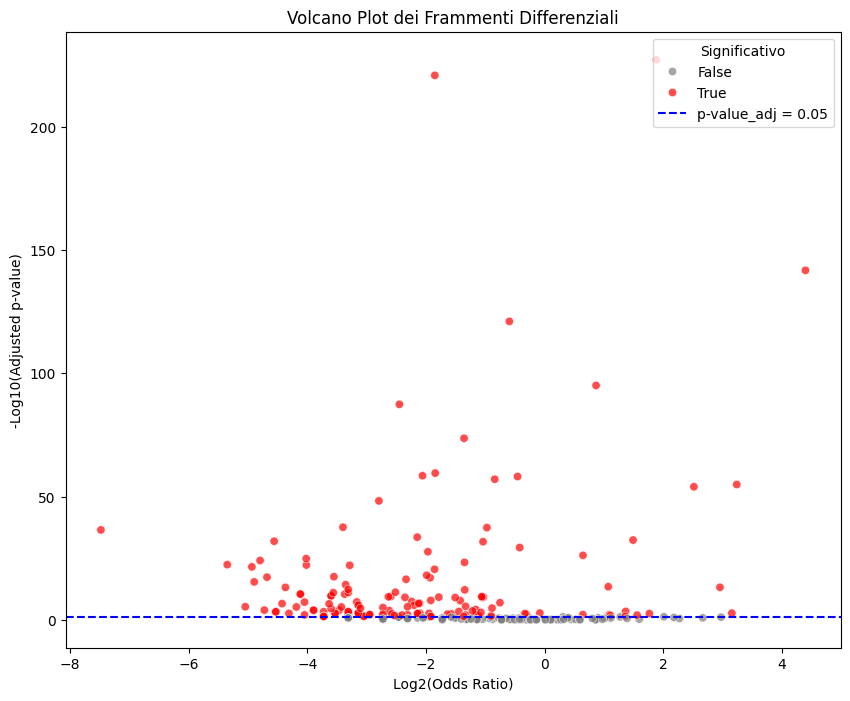

In [21]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calcola log2 Odds Ratio e -log10 p-value aggiustato
frequency_table['log2_OR'] = np.log2(frequency_table['Odds_Ratio'])
frequency_table['neg_log10_p_adj'] = -np.log10(frequency_table['p-value_adj'])

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=frequency_table,
    x='log2_OR',
    y='neg_log10_p_adj',
    hue=frequency_table['p-value_adj'] < 0.05,
    palette={True: 'red', False: 'grey'},
    alpha=0.7
)
plt.axhline(-np.log10(0.05), color='blue', linestyle='--', label='p-value_adj = 0.05')
plt.xlabel('Log2(Odds Ratio)')
plt.ylabel('-Log10(Adjusted p-value)')
plt.title('Volcano Plot dei Frammenti Differenziali')
plt.legend(title='Significativo', loc='upper right')
plt.show()

b. Bar Plot dei Top Frammenti Arricchiti
Visualizza i frammenti più arricchiti in ciascuna classe.

C:\Users\Marco\AppData\Local\Temp\ipykernel_22260\3462134581.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


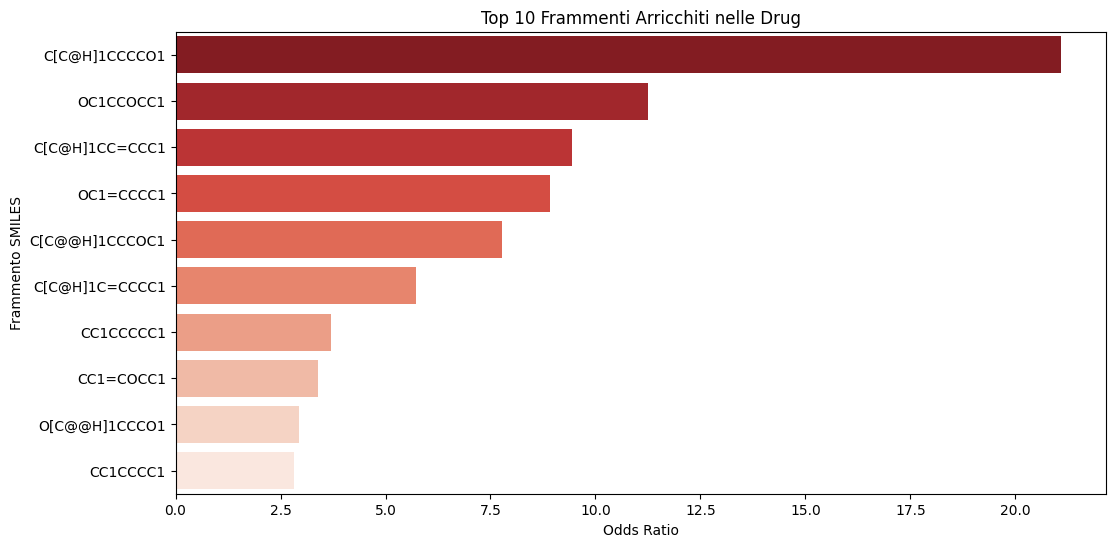

AttributeError: Rectangle.set() got an unexpected keyword argument 'negative'

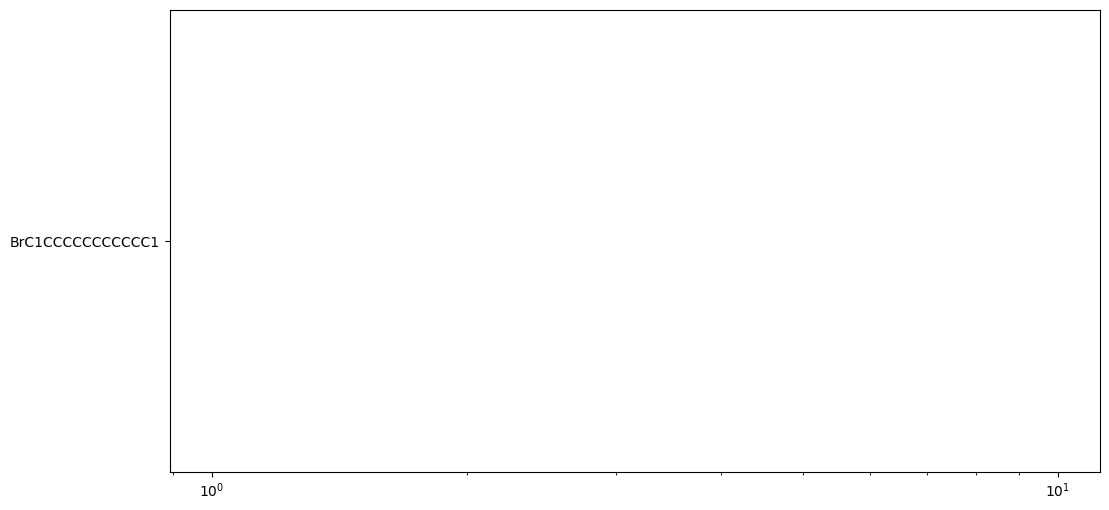

In [26]:
# Top 10 frammenti arricchiti nelle Drug
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Odds_Ratio',
    y='SMILES',
    data=top_enriched_drug,
    palette='Reds_r'
)
plt.xlabel('Odds Ratio')
plt.ylabel('Frammento SMILES')
plt.title('Top 10 Frammenti Arricchiti nelle Drug')
plt.show()

# Top 10 frammenti arricchiti nelle Non-Drug
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Odds_Ratio',
    y='SMILES',
    data=top_enriched_nondrug
)
plt.xlabel('Odds Ratio')
plt.ylabel('Frammento SMILES')
plt.title('Top 10 Frammenti Arricchiti nelle Non-Drug')
plt.show()


Questa parte è per il confronto usando i cluster


In [ ]:
# Funzione per calcolare l'impronta digitale (fingerprint) a partire da una stringa SMILES
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        return fp
    else:
        return None

# Aggiungiamo le impronte digitali ai DataFrame
def add_fingerprints(df):
    fingerprints = []
    for smiles in df['SMILES']:
        fp = get_fingerprint(smiles)
        fingerprints.append(fp)
    df['Fingerprint'] = fingerprints
    return df

fragments_drug = add_fingerprints(fragments_drug)
fragments_nondrug = add_fingerprints(fragments_nondrug)

# Funzione per trovare il frammento più vicino al centroide del cluster
def get_representative_fragments(df):
    representative_fragments = {}
    clusters = df['Cluster'].unique()
    for cluster in clusters:
        cluster_df = df[df['Cluster'] == cluster]
        fps = [fp for fp in cluster_df['Fingerprint'] if fp is not None]
        if not fps:
            continue  # Salta il cluster se non ci sono fingerprints validi
        # Convertiamo le impronte digitali in array numpy
        fp_array = []
        for fp in fps:
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fp_array.append(arr)
        fp_array = np.array(fp_array)
        # Calcoliamo il centroide
        centroid = np.mean(fp_array, axis=0)
        # Troviamo il frammento più vicino al centroide
        similarities = []
        for fp in fps:
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            similarity = 1 - np.linalg.norm(arr - centroid)
            similarities.append(similarity)
        max_idx = np.argmax(similarities)
        representative_fragment = cluster_df.iloc[max_idx]['SMILES']
        representative_fragments[cluster] = representative_fragment
    return representative_fragments

rep_fragments_drug = get_representative_fragments(fragments_drug)
rep_fragments_nondrug = get_representative_fragments(fragments_nondrug)

# Visualizziamo i frammenti rappresentativi
print("\nFrammenti rappresentativi (Drug):")
for cluster, smiles in rep_fragments_drug.items():
    print(f"Cluster {cluster}: {smiles}")

print("\nFrammenti rappresentativi (Non-Drug):")
for cluster, smiles in rep_fragments_nondrug.items():
    print(f"Cluster {cluster}: {smiles}")
